# Определение перспективного тарифа для телеком-компании

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год, а также данные по тарифу. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

# План работы 

- [Обзор и предобработка данных](#предобработка)
- [Анализ данных](#анализ)
- [Проверка гипотез](#гипотезы)
- [Вывод](#вывод)


# Обзор и предобработка данных <a id='предобработка'></a>

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from math import factorial
import numpy as np
from scipy import stats as st
import math as mt
pd.set_option('display.float_format', '{:,.2f}'.format)

Импортируем необходимые для работы библиотеки

In [86]:
data = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Импортировал все датасеты. Для начала поработаем с данными, приведем к нужным форматам. 

In [87]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Сменил название колонки на tariff, чтобы можно было потом прицепить датасет к data по колонке tariff для облегчения доступа к данным.

In [88]:
data['reg_date'] = pd.to_datetime(data['reg_date'], format='%Y.%m.%d')
data['churn_date'] = pd.to_datetime(data['churn_date'], format='%Y.%m.%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [89]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
calls['duration'] = calls['duration'].round().astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [90]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')
internet['mb_used'] = internet['mb_used'].round().astype('int')
internet.head(15)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113,2018-11-25,1000
1,1,1000_1,1053,2018-09-07,1000
2,2,1000_2,1197,2018-06-25,1000
3,3,1000_3,550,2018-08-22,1000
4,4,1000_4,303,2018-09-24,1000
5,5,1000_5,400,2018-10-02,1000
6,6,1000_6,540,2018-09-07,1000
7,7,1000_7,416,2018-07-11,1000
8,8,1000_8,505,2018-10-08,1000
9,9,1000_9,346,2018-09-03,1000


In [91]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [92]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff                   2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Поскольку нам потребуется информация, сортированная по месяцам, можно сразу сменить формат данных в колонках с датой во всех датасетах. По каждому датасету провожу преобразования в формат int и datetime

In [93]:
calls['month'] = calls['call_date'].dt.month
calls = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
calls['duration'] = np.ceil(calls['duration'])
calls

,user_id,month,duration
0,1000,5,149.00
1,1000,6,159.00
2,1000,7,319.00
3,1000,8,391.00
4,1000,9,439.00
...,...,...,...
3169,1498,10,230.00
3170,1499,9,64.00
3171,1499,10,429.00
3172,1499,11,574.00


In [94]:
messages['month'] = messages['message_date'].dt.month
messages = messages.groupby(['user_id', 'month'])['message_date'].count().reset_index()
messages

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [95]:
internet['month'] = internet['session_date'].dt.month
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet

,user_id,month,mb_used
0,1000,5,2253
1,1000,6,23232
2,1000,7,14004
3,1000,8,14054
4,1000,9,14569
...,...,...,...
3198,1498,10,20581
3199,1499,9,1846
3200,1499,10,17792
3201,1499,11,17963


In [96]:
internet['mb_used'] = internet['mb_used'] / 1024
internet

,user_id,month,mb_used
0,1000,5,2.20
1,1000,6,22.69
2,1000,7,13.68
3,1000,8,13.72
4,1000,9,14.23
...,...,...,...
3198,1498,10,20.10
3199,1499,9,1.80
3200,1499,10,17.38
3201,1499,11,17.54


In [97]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int')
internet

,user_id,month,mb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15
...,...,...,...
3198,1498,10,21
3199,1499,9,2
3200,1499,10,18
3201,1499,11,18


In [98]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объединяем таблицы

In [99]:
calls = calls.merge(messages, on=['user_id', 'month'], how='outer')
full = internet.merge(calls, on=['user_id', 'month'], how='outer')
data = data.merge(full, on=['user_id'], how='outer')
data_full = data.merge(tariffs, on=['tariff'], how='outer')
data_full.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,duration,message_date,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.00,3.00,149.00,22.00,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.00,23.00,159.00,60.00,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.00,14.00,319.00,75.00,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.00,14.00,391.00,81.00,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.00,15.00,439.00,57.00,1000,30720,3000,1950,150,1,1


In [100]:
data_full = data_full.rename(columns={'message_date': 'messages'})
data_full = data_full.rename(columns={'mb_used': 'gb_used'})
data_full['mb_per_month_included'] = data_full['mb_per_month_included'] / 1024
data_full = data_full.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
data_full.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,duration,messages,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.00,3.00,149.00,22.00,1000,30.00,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.00,23.00,159.00,60.00,1000,30.00,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.00,14.00,319.00,75.00,1000,30.00,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.00,14.00,391.00,81.00,1000,30.00,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.00,15.00,439.00,57.00,1000,30.00,3000,1950,150,1,1


In [101]:
data_full.shape

(3216, 19)

In [102]:
data_full.user_id.nunique()

500

Все таблицы присоединили, ни один клиент не потерялся

In [103]:
data_full['gb_used'] = data_full['gb_used'].fillna(0)
data_full['duration'] = data_full['duration'].fillna(0)
data_full['messages'] = data_full['messages'].fillna(0)
data_full.info()

#columns = ['gb_used', 'duration', 'messages'] В цикле можно еще сделать
#for i in columns:
#    df[i] = df[i].fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month                    3214 non-null float64
gb_used                  3216 non-null float64
duration                 3216 non-null float64
messages                 3216 non-null float64
messages_included        3216 non-null int64
gb_per_month_included    3216 non-null float64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes:

In [104]:
data_full['gb_used_over'] = (data_full['gb_used'] - data_full['gb_per_month_included']) * data_full['rub_per_gb']
data_full['gb_used_over'] = data_full['gb_used_over'].astype('int')
data_full.loc[data_full['gb_used_over'] < 0, 'gb_used_over'] = 0

data_full['minutes_over'] = (data_full['duration'] - data_full['minutes_included']) * data_full['rub_per_minute']
data_full['minutes_over'] = data_full['minutes_over'].astype('int')
data_full.loc[data_full['minutes_over'] < 0, 'minutes_over'] = 0

data_full['messages_over'] = (data_full['messages'] - data_full['messages_included']) * data_full['rub_per_message']
data_full['messages_over'] = data_full['messages_over'].astype('int')
data_full.loc[data_full['messages_over'] < 0, 'messages_over'] = 0

data_full['fee'] = data_full['gb_used_over'] + data_full['minutes_over'] + data_full['messages_over'] + data_full['rub_monthly_fee']
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 23 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month                    3214 non-null float64
gb_used                  3216 non-null float64
duration                 3216 non-null float64
messages                 3216 non-null float64
messages_included        3216 non-null int64
gb_per_month_included    3216 non-null float64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
gb_used

Необходимо провести работу с датасетами, сгруппировать данные по пользователю и месяцу. Номер месяца вынести в отдельную колонку для облегчения работы с информацией. Потом склеим датасеты. Получил полный датасет со всей необходимой информацией. Перевел мегабайты в гигабайты. Пропуски в датасете решил заменить на "0". Считаем выручку с каждого клиента за месяц.

In [105]:
data_full['fee'].describe()

count   3,216.00
mean    1,506.02
std       792.82
min       550.00
25%       735.25
50%     1,566.50
75%     1,950.00
max     6,617.00
Name: fee, dtype: float64

# Анализ данных <a id='анализ'></a>

In [106]:
data_full.groupby('tariff').agg({'duration': ['mean', 'std', 'var']})

duration                 
           mean    std       var
tariff                          
smart    394.09 180.05 32,416.32
ultra    496.39 299.97 89,982.19

In [107]:
data_full.groupby('tariff').agg({'messages': ['mean', 'std', 'var']})

messages               
           mean   std      var
tariff                        
smart     33.37 28.23   796.96
ultra     49.31 47.81 2,285.42

In [108]:
data_full.groupby('tariff').agg({'gb_used': ['mean', 'std', 'var']})

gb_used           
          mean  std   var
tariff                   
smart    16.32 5.76 33.14
ultra    19.47 9.87 97.38

In [ ]:
# Можно также посчитать через функцию

#def val (columns):
#    values = data_full.groupby('tariff').agg({columns: ['mean', 'std', 'var']})
#    print (values)

#columns = ['duration', 'messages', 'gb_used']
#for i in columns:
#    val(i)

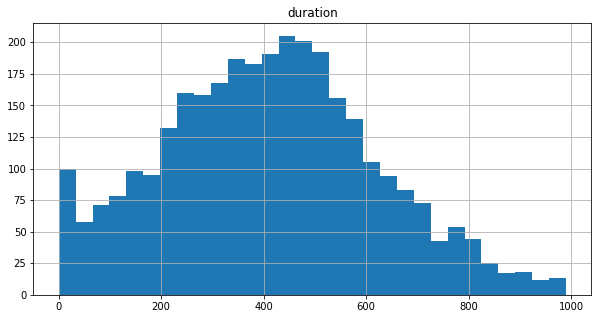

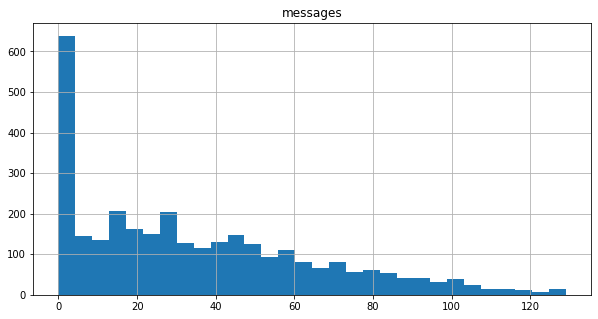

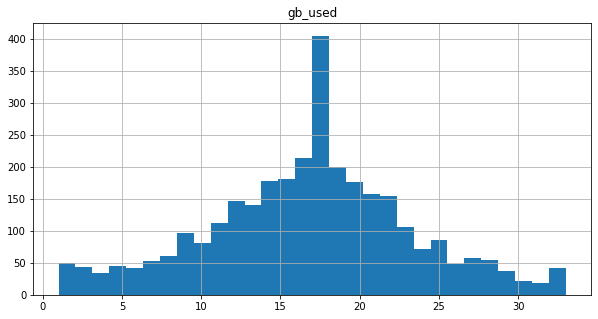

In [109]:
for col in ['duration', 'messages', 'gb_used']:
    q1 = data_full[col].quantile(0.25)
    q3 = data_full[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - iqr * 1.5
    high = q3 + iqr * 1.5
    min_val = data_full[col].min()
    max_val = data_full[col].max()
    
    if min_val >= low:
        min = min_val
    else:
        min = low
    if max_val <= high:
        max = max_val
    else:
        max = high
    
    hist = data_full[col].hist(bins=30, figsize=(10,5), range=(min, max))
    hist.set_title(col)
    plt.show()

Duration - распределение нормальное
Messages - распределение Пуассона, датасет с положительной скошенностью
gb_used - распределение нормальное

# Проверка гипотез <a id='гипотезы'></a>

Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются
Н0 - средняя выручка равна
Н1 - средняя выручка различается


In [110]:
sample_ultra = data_full[data_full['tariff'] == 'ultra']['fee']
sample_smart = data_full[data_full['tariff'] == 'smart']['fee']

alpha = 0.05
results = st.ttest_ind(sample_ultra, sample_smart)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось опровергнуть нулевую гипотезу')

p-значение 4.276358940388949e-179
Отвергаем нулевую гипотезу


Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Н0 - средняя выручка примерно равна
Н1 - средняя выручка отличается

In [111]:
sample_msc = data_full[data_full['city'] == 'Москва']['fee']
sample_other_cities = data_full[data_full['city'] != 'Москва']['fee']

alpha = 0.05
results = st.ttest_ind(sample_msc, sample_other_cities)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось опровергнуть нулевую гипотезу')

p-значение 0.4802331076608557
Не получилось опровергнуть нулевую гипотезу


В обоих случаях сопоставляем две генеральные совокупности. Уровень значимости задаю стандартный - 5%.

# Вывод <a id='вывод'></a>

Выяснил, что в среднем по тарифу смарт люди тратят примерно 400 минут в месяц и 500 минут для тарифа Ультра. Сообщения: смарт - примерно 34 и ультра - 50. По интернет трафику: смарт - примерно 16 ГБ и ультра - 20 ГБ. Большую выручку оператор получает от владельцев тарифа Смарт, там пользователи часто берут дополнительные пакеты минут, сообщенией, интернета. Исходя из данных видно, что в независимости от места нахождения пользователей, выручка примерно будет равна. 